In [181]:
# Домашка 1 и 3 по разделу ML 

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

RN = 1234 #fix random_state

In [182]:
df = pd.read_csv('train.csv')
# закодируем поле Sex методом OneHotEncoding
# LabelEncoding для лин.регрессии использовать нецелесообразно из-за возникающей
# для модели неопределенности, что одно число больше или меньше другого
# хотя это просто номера групп
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

# удалим фичи бесполезные для модели
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp'], inplace=True)

df.sample(3)

,Survived,Pclass,Age,Parch,Fare,Sex_male
282,0,3,16.0,0,9.5000,1
196,0,3,NaN,0,7.7500,1
358,1,3,NaN,0,7.8792,0


In [183]:
# разделяем на test, train
X, y = df.drop(columns='Age'), df.Age
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=RN)

print(X_train.shape, X_test.shape)

(623, 5) (268, 5)


In [184]:
# заполним пропущенные значения целевой переменной Age
# средним возрастом в соответствующей группе (['Pclass', 'Sex_male'])
# раздельно для тестовой и обучающей выборки
# чтобы исключить влияние train на test
def fill_na(X, y):
    df = pd.concat([X, pd.DataFrame(y)], axis=1)
    mean_age = df.groupby(['Pclass', 'Sex_male'])['Age'].mean().reset_index().set_index(['Pclass', 'Sex_male'])
    df_age = df[df['Age'].isna()][['Pclass', 'Sex_male', 'Age']].reset_index().set_index(['Pclass', 'Sex_male'])
    df_age.Age = mean_age.Age
    df_age = df_age.reset_index(drop=True).set_index(['index'])
    y.fillna(df_age.Age, inplace=True)


fill_na(X_train, y_train)
fill_na(X_test, y_test)

In [185]:
#удалим отсутствующие значения
X_train = X_train[~X_train.isnull().any(axis=1)]
X_test = X_test[~X_test.isnull().any(axis=1)]
X_train.info(), X_test.info()
X_train.name = X_test.name = 'base'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 28 to 815
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  623 non-null    int64  
 1   Pclass    623 non-null    int64  
 2   Parch     623 non-null    int64  
 3   Fare      623 non-null    float64
 4   Sex_male  623 non-null    uint8  
dtypes: float64(1), int64(3), uint8(1)
memory usage: 24.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 523 to 63
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  268 non-null    int64  
 1   Pclass    268 non-null    int64  
 2   Parch     268 non-null    int64  
 3   Fare      268 non-null    float64
 4   Sex_male  268 non-null    uint8  
dtypes: float64(1), int64(3), uint8(1)
memory usage: 10.7 KB


In [186]:
# стандартизируем признаки, рассчитываем коэффициенты только на train, а применим и на train и на test
# для исключения "подмешивания" результата в test
sc = MinMaxScaler()
X_train_scaled = pd.DataFrame(data=sc.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=sc.transform(X_test), columns=X_test.columns)
X_train_scaled.name = X_test_scaled.name = 'scaled'

In [187]:
# 1. Датасет titanic, разделить на train/test в пропорции 0.7/0.3
# 2. Предсказать возраст Age на основании других параметров (отберите сами какие)

# обучаем и предсказываем с помощью обычной LR
# и с регуляризацией 2 и 1 порядка (Ridge, Lasso)
models = [LinearRegression(), Ridge(), Lasso()]
result = {'predict':[],
          'mae':[],
          'mse':[]}
def predicts(X_train, X_test, models=models):
    global result, y_train, y_test
    for model in models:
        name_model = model.__str__().replace("()", "")+' with \'' + X_train.name +'\' feachers'
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        mse = mean_squared_error(y_test, predict)
        mae = mean_absolute_error(y_test, predict)
        print(f'\nError on {name_model}: \
                \nMAE: {mae}, MSE: {mse}')
        result['mse'].append({name_model:mse, })
        result['mae'].append({name_model:mae})
        result['predict'].append({name_model:predict})
    print('---------------------------------------')

predicts(X_train, X_test)
predicts(X_train_scaled, X_test_scaled)


Error on LinearRegression with 'base' feachers:                 
MAE: 8.4584932390468, MSE: 131.88107797614

Error on Ridge with 'base' feachers:                 
MAE: 8.451577348050886, MSE: 131.78109828032686

Error on Lasso with 'base' feachers:                 
MAE: 8.308305701224501, MSE: 135.42368413296686
---------------------------------------

Error on LinearRegression with 'scaled' feachers:                 
MAE: 8.458493239046794, MSE: 131.88107797613978

Error on Ridge with 'scaled' feachers:                 
MAE: 8.437792605383567, MSE: 132.00366062202826

Error on Lasso with 'scaled' feachers:                 
MAE: 8.353298344356368, MSE: 141.1164187478937
---------------------------------------


In [188]:
# произведем отбор призников на основе дисперсии < 0.01
var_feachers = X_test_scaled.var().sort_values()
print(f'Дисперсии изначальных признаков:\n{var_feachers}')

vs = VarianceThreshold(0.01)
X_train_var = pd.DataFrame(data=vs.fit_transform(X_train_scaled), columns=X_train_scaled.columns[vs.get_support()])
X_test_var = pd.DataFrame(data=vs.transform(X_test_scaled), columns=X_test_scaled.columns[vs.get_support()])

X_train_var.name = X_test_scaled.name = 'variance'
print(f'\nОтобранные признаки: {X_test_var.columns.to_list()}')

predicts(X_train_var, X_test_var, models)

Дисперсии изначальных признаков:
Fare        0.009854
Parch       0.014317
Pclass      0.172016
Sex_male    0.220065
Survived    0.236626
dtype: float64

Отобранные признаки: ['Survived', 'Pclass', 'Parch', 'Sex_male']

Error on LinearRegression with 'variance' feachers:                 
MAE: 8.442183622440245, MSE: 133.05976057822173

Error on Ridge with 'variance' feachers:                 
MAE: 8.42696438243829, MSE: 133.11074408206775

Error on Lasso with 'variance' feachers:                 
MAE: 8.353298344356368, MSE: 141.1164187478937
---------------------------------------


In [189]:
# # посмотрим на важность фич модели DecisionTreeRegressor()
# fi = pd.DataFrame(data=[result['models'][3].feature_importances_,
#                         X_train.columns]).T.rename(columns={0:'Важность', 1:'Фича'})
# fi.sort_values(by='Важность', ascending=False)

### Вывод:
с предсказанием возраста линейной моделью в этом датасете
из рассмотренных примеров лучше всего справилась модель с L1 регуляризацией(Lasso) без масштабирования признаков: **MAE=8.308**

In [190]:
# 3. Подобрать оптимальные гиперпараметры модели с помощью GridSearch, в идеале получить лучшее качество на test

In [191]:
# попробуем предсказать возраст методами РешающихДеревьев и СлучайногоЛеса
# используя стандартизированные выборки X_train_scaled, X_test_scaled и X_train_var, X_train_var

In [192]:
models = [DecisionTreeRegressor(), RandomForestRegressor()]

predicts(X_train, X_test, models)
predicts(X_train_scaled, X_test_scaled, models)
predicts(X_train_var, X_test_var, models)


Error on DecisionTreeRegressor with 'base' feachers:                 
MAE: 10.624043168750385, MSE: 214.20561077026102

Error on RandomForestRegressor with 'base' feachers:                 
MAE: 9.1031837365823, MSE: 150.89653185372256
---------------------------------------

Error on DecisionTreeRegressor with 'scaled' feachers:                 
MAE: 10.534490929944411, MSE: 208.24817003277198

Error on RandomForestRegressor with 'scaled' feachers:                 
MAE: 9.11358197196828, MSE: 151.09472943157905
---------------------------------------

Error on DecisionTreeRegressor with 'variance' feachers:                 
MAE: 8.311438737758099, MSE: 129.37151402094526

Error on RandomForestRegressor with 'variance' feachers:                 
MAE: 8.242169758010892, MSE: 127.42863848744437
---------------------------------------


In [193]:
# используем RandomizedSearchCV и GridSearchSV для подбора гиперпараметров Случайного леса
# сначала прикинем параметры случайным образом RandomizedSearchCV

# n_estimators — число «деревьев» в «случайном лесу».
# max_features — число признаков для выбора расщепления.
# max_depth — максимальная глубина деревьев.
# min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
# min_samples_leaf — минимальное число объектов в листьях.
# bootstrap — использование для построения деревьев подвыборки с возвращением.


n_estimators = range(10, 1100, 100)
max_features = ['log2', 'sqrt']
max_depth = range(1, 20)            
min_samples_split = range(2, 55, 5)
min_samples_leaf = range(2, 55, 5)
bootstrap = [True, False]

param_dist =  {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(RandomForestRegressor(), 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)

rs.fit(X_train_var, y_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 510,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 16,
 'bootstrap': False}

In [194]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)

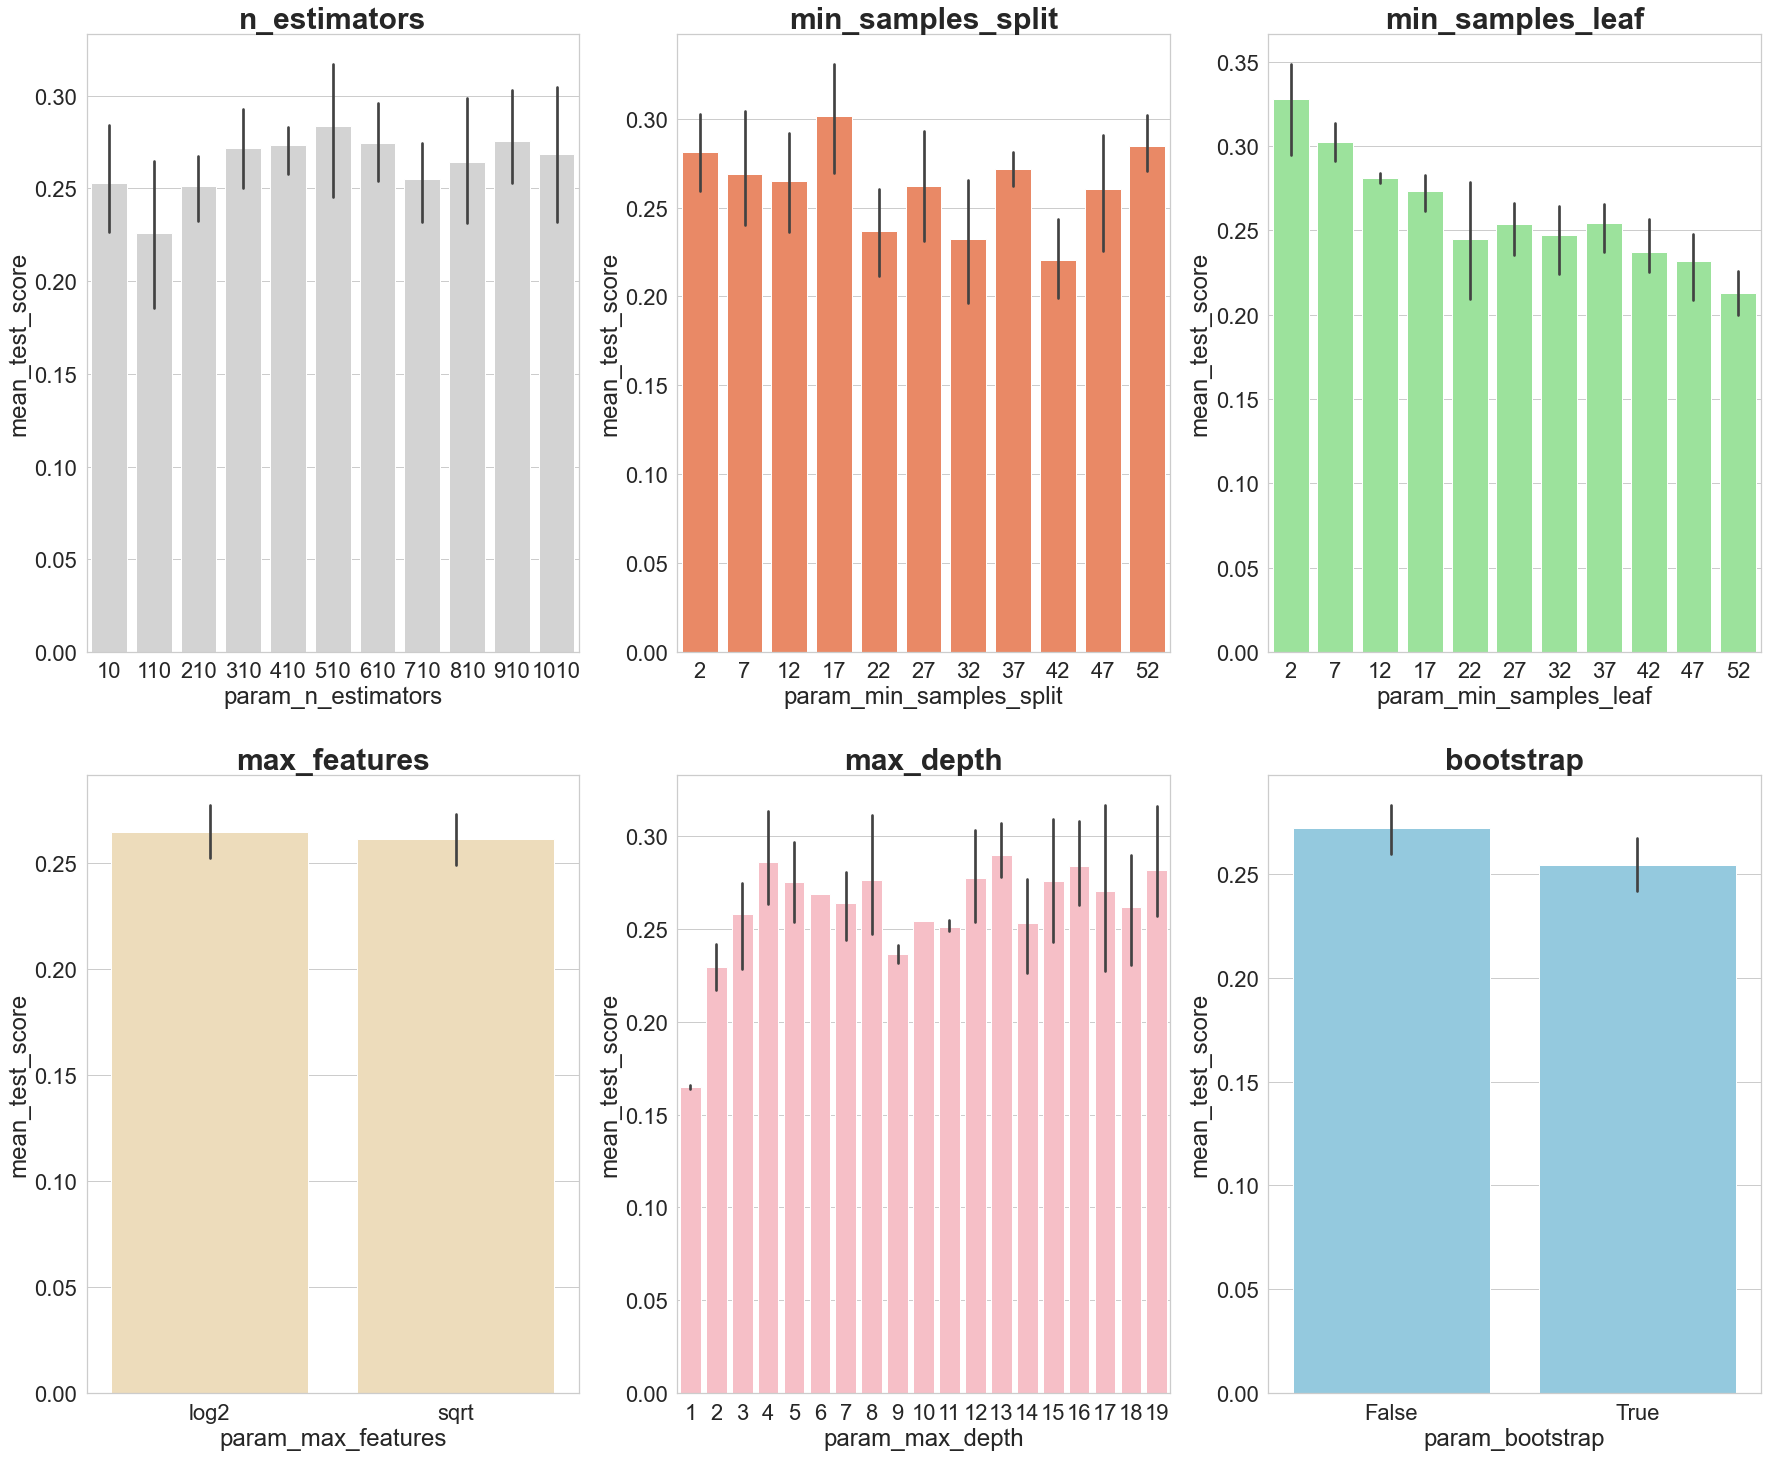

In [195]:
# отрисуем и по картинке прикинем диапазоны для GridSearchSV

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
#axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
#axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
#axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
#axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
#axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
#axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [197]:
# на второй итерации GridSearchSV рассмотрим параметры
# из близкого диапазона лучших параметров, полученных на первой итерации

n_estimators = [510]
min_samples_split = range(25, 29)
min_samples_leaf = range(2, 7)
max_features = ['sqrt']
max_depth = [4, 8, 12, 13, 16, 19]
bootstrap = [False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(RandomForestRegressor(), param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
best_param = gs.best_params_

Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [198]:
best_param = gs.best_params_
best_param

{'bootstrap': False,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 25,
 'n_estimators': 510}

In [199]:
models = [RandomForestRegressor(), RandomForestRegressor(**best_param)]
predicts(X_train_var, X_test_var, models)


Error on RandomForestRegressor with 'variance' feachers:                 
MAE: 8.230839074954066, MSE: 126.34315917342143

Error on RandomForestRegressor(bootstrap=False, max_depth=12, max_features='sqrt',
                      min_samples_leaf=5, min_samples_split=25,
                      n_estimators=510) with 'variance' feachers:                 
MAE: 8.133565996366267, MSE: 124.43651521143747
---------------------------------------


### Вывод:
немного улучшили качество СлучайногоЛеса подбором гиперпараметров: **MAE=8.133**